# Chapter 16 - Natural Language Processing: Applications

Given pretrained text representations, we will explore how sentiment analysis and natural language inference can be accomplished in practice.

![](../imgs/ch16/nlp-map-app.svg)

## 16.1. Sentiment Analysis and the Dataset

The *sentiment analysis* task aims to study people's sentiments in their produced text, such as product reviews, blog comments, and forum discussions. It enjoys wide applications to fields as diverse as politics (e.g., analysis of public sentiments towards policies), finance (e.g., analysis of sentiments of the market), and marketing (e.g., product research and brand management).

Sentiment analysis can be considered as a text classification task, which *transforms a varying-length text sequence into a fixed-length text category*.

In [1]:
import os
import torch
import torch.nn as nn

from d2l import torch as d2l

### 16.1.1. Reading the Dataset

In [2]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

Next, read the training and test datasets.

Each example is a review and its corresponding sentiment label: 1 for "positive" and 0 for "negative".

In [3]:
def read_imdb(data_dir, is_train):
    '''Read the IMDb review dataset text sequences and labels'''
    data, labels = [], []

    for label in ('pos', 'neg'):
        folder_name = os.path.join(
            data_dir,
            'train' if is_train else 'test',
            label
        )

        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                # Each review is stored as a single line of text
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    
    return data, labels

In [4]:
train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
label: 1 review: Homelessness (or Houselessness as George Carlin stated) has 
label: 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


### 16.1.2. Preprocessing the Dataset

Treating each word as a token and filtering out words that appear less than 5 times.

In [6]:
# tokenize the text into words
train_tokens = d2l.tokenize(train_data[0], token='word')
# create a vocabulary
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

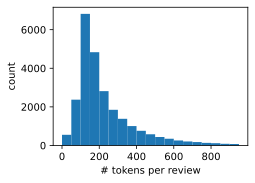

In [7]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist(
    [len(line) for line in train_tokens],
    bins=range(0, 1000, 50)
);

The reviews have different numbers of tokens. To process a minibatch of such reviews at each time, we set the length of each review to 500 with truncation and padding.

In [8]:
num_steps = 500 # sequence length

train_features = torch.tensor(
    [d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']
    ) for line in train_tokens]
)
print(train_features.shape)

torch.Size([25000, 500])


### 16.1.3. Creating the Data Iterator

In [9]:
train_iter = d2l.load_array(
    data_arrays=(train_features, torch.tensor(train_data[1])),
    batch_size=64
)

In [10]:
for X, y in train_iter:
    print('review shape:', X.shape, ', label shape:', y.shape)
    break

print('# batches:', len(train_iter))

review shape: torch.Size([64, 500]) , label shape: torch.Size([64])
# batches: 391


### 16.1.4. Putting It All Together

The `load_data_imdb` function wraps up all the preceding steps and returns the data iterators and the vocabulary of the IMDb review dataset.

In [11]:
def load_data_imdb(batch_size, num_steps=500):
    '''Return data iterator and vocabulary of the IMDb review dataset'''
    # download and read the IMDB review dataset
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)

    # tokenize the text into words
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    # create a vocabulary of tokens
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    # truncate and pad text sequences
    train_features = torch.tensor(
        [d2l.truncate_pad(
            vocab[line], num_steps, vocab['<pad>']
        ) for line in train_tokens]
    )
    test_features = torch.tensor(
        [d2l.truncate_pad(
            vocab[line], num_steps, vocab['<pad>']
        ) for line in test_tokens]
    )

    # create data iterators
    train_iter = d2l.load_array(
        data_arrays=(train_features, torch.tensor(train_data[1])),
        batch_size=batch_size
    )
    test_iter = d2l.load_array(
        data_arrays=(test_features, torch.tensor(test_data[1])),
        batch_size=batch_size,
        is_train=False
    )

    return train_iter, test_iter, vocab

## 16.2. Sentiment Analysis: Using RNNs

In this section, we will follow the diagram below to represent each token using the pretrained GloVe model in the IMDb review dataset, and feed these token representations into a multiplayer bidrectional RNN to obtain the text sequence representation, which will then be transformed into sentiment analysis outputs.

![](../imgs/ch16/nlp-map-sa-rnn.svg)

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

In [2]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### 16.2.1. Representing Single Text with RNNs

In text classifications tasks, such as sentiment analysis, a varying-length text sequence will be transformed into fixed-length categories.

In the `BiRNN` class, while each token of a text sequence gets its individual pretrained GloVe representation via the embedding layer (`self.embedding`), the entire sequence is encoded by a bidirectional RNN (`self.encoder`).

The hidden states (at the last layer) of the bidirecitonal LSTM at both the initial and final time steps are concatenated as the representation of the text sequence. This single text representation is then transformed into output categories by a fully-connected layer (`self.decoder`) with two outputs ("positive" and "negative").

In [3]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)

        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_size)
        
        # set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(
            input_size=embed_size,
            hidden_size=num_hiddens,
            num_layers=num_layers,
            bidirectional=True
        )
        self.decoder = nn.Linear(in_features=4*num_hiddens,
                                 out_features=2)
        
    def forward(self, inputs):
        # The shape of `inputs` is (batch size, num_steps).
        # Because LSTM requires its input's first dimension to be
        # the temporal dimension, the input is transposed before
        # obtaining token representations.
        # The output shape is (num_steps, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)

        self.encoder.flatten_parameters()
        # Return hidden states of the last hidden layer at different time steps.
        # The shape of `outputs` is (num_steps, batch size, 2 * num_hiddens).
        outputs, _ = self.encoder(embeddings)

        # Concatenate the hidden states at the initial and final time steps 
        # as the input of the fully-connected layer.
        # Its shape is (batch size, 4 * num_hiddens)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=-1)
        outs = self.decoder(encoding)

        return outs

Now we can construct a directional RNN with 2 hidden layers to represent single text for sentiment analysis.

In [4]:
embed_size = 100
num_hiddens = 100
num_layers = 2
devices = d2l.try_all_gpus()

net = BiRNN(vocab_size=len(vocab),
            embed_size=embed_size,
            num_hiddens=num_hiddens,
            num_layers=num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if 'weight' in param:
                nn.init.xavier_uniform_(module._parameters[param])

# apply the initializer to all the weights of model
net.apply(init_weights);

### 16.2.2. Loading Pretrained Word Vectors

We need to load the pretrained 100-dimensional (**needs to be consistent with** `embed_size`) GloVe embeddings for tokens in the vocabulary.

In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

We can use these pretrained word vectors to represent tokens in the reviews and will not update these vectors during training.

In [6]:
# set the embedding layer's weight to pretrained embedding `embeds`
net.embedding.weight.data.copy_(embeds)
# set the embedding layer not to update during training
net.embedding.weight.requires_grad = False

### 16.2.3. Training and Evaluation the Model

In [7]:
lr = 0.01
num_epochs = 5

trainer = torch.optim.Adam(net.parameters(), lr=lr)

loss = nn.CrossEntropyLoss(reduction='none')

loss 0.307, train acc 0.869, test acc 0.848
320.4 examples/sec on [device(type='cuda', index=0)]


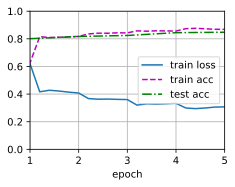

In [8]:
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [9]:
def predict_sentiment(net, vocab, sequence):
    '''Predict the sentiment of a text sequence'''
    sequence = torch.tensor(vocab[sequence.split()],
                            device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)),
                         dim=1)
    
    return 'positive' if label == 1 else 'negative'

We can now use the trained model to predict the sentiment for two simple sentences.

In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 16.3. Sentiment Analysis: Using CNNs

Though originally designed for computer vision, CNNs are also widely used for natural language processing. We can think of any text sequence as a one-dimensional image. In this way, one-dimensional CNNs can process local features such as $n$-grams in text.

In this section, we will use the *textCNN* model to demonstrate how to design a CNN architecture for representing single text, following the diagram below.

![](../imgs/ch16/nlp-map-sa-cnn.svg)

In [12]:
import torch
from torch import nn

from d2l import torch as d2l

In [13]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### 16.3.1. One-Dimensional Convolutions

![](../imgs/ch16/conv1d.svg)

In the figure above, the convolution window in 1D case slides from left to right across the input tensor.

The `corr1d` functrion is used to compute the 1D cross-correlation, given an input tensor `X` and a kernel tensor `K`.

In [14]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i : i + w] * K).sum()
    
    return Y

In [15]:
# test
X = torch.tensor([0, 1, 2, 3, 4, 5, 6])
K = torch.tensor([1, 2])

corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

For a one-dimensional input with multiple channels, the convolution kernel needs to have the same number of input channels. For each channel, we perform a cross-correlation on the one-dimensional tensor of the input and the one-dimensional tensor of the kernel, summing the results over all the channels to produce the one-dimensional output tensor, as shown in the figure below.

![](../imgs/ch16/conv1d-channel.svg)

In [16]:
def corr1d_multi_in(X, K):
    # Iterate through the 0th dimension (channel dimension) of `X` and `K`
    # Then, add them together
    res = [corr1d(x, k) for x,k in zip(X, K)]
    return sum(res)

In [17]:
# test
X = torch.tensor([
    [0, 1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7, 8]
])
K = torch.tensor([
    [1, 2],
    [3, 4],
    [-1, -3]
])

corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

The *multi-input-channel* one-dimensional cross-correlations are equivalent to the *single-input-channel* two-dimensional cross-correlations. An equivalent form of the multi-input-channel one-dimensional cross-correlation, in the figure above, is the *single-input-channel* two-dimensional cross-correlation, shown in the figure below., where the height of the convolution kernel has to be the same as that of the input tensor.

![](../imgs/ch16/conv1d-2d.svg)

### 16.3.2. Max-Over-Time Pooling

We can use pooling to extract the highest value from sequence representations as the most important feature across time steps.

The *max-over-time pooling* used in textCNN works like the one-dimensional global max-pooling.

For a multi-channel input where each channel stores values at different time steps, the output at each channel is the maximum value for that channel. The max-over-time pooling allows different numbers of time steps at different channels.

### 16.3.3. The textCNN Model

The textCNN model uses 1D convolution and max-over-time pooling, takes individual pretrained token representations as input, then obtains and transforms sequence representations for the downstream applications.

For a single text sequence with $n$ tokens represented by $d$-dimensional vectors, the width, height, and number of channels of the input tensors are $n$, 1, and $d$, respectively. The textCNN model transforms the input tensor into the output by:
1. defining multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.
2. performing max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.
3. transforming the concatenated vector into the output categories using the fully-connected layer. Dropout can be used to regularize the model.

![](../imgs/ch16/textcnn.svg)

The figure above shows the model architecture of textCNN with a concrete example.

#### 16.3.3.1. Defining the Model

Compared with the bidirectional RNN model in the previous section, we also use two embedding layers: one with trainable weights and the other with fixed pretrained weights.

In [19]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, nums_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)

        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_size)
        
        # the constant_embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embed_size)
        
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(nums_channels), 2)

        # the max-over-time pooling layer has no parameters,
        # so this instance can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()

        # create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(nums_channels, kernel_sizes):
            self.convs.append(
                nn.Conv1d(2 * embed_size, c, k)
            )

    def forward(self, inputs):
        # concatenate two embedding layer outputs with shape 
        # (batch size, no. of tokens, word vector dimension) along vectors
        embeddings = torch.cat(
            (self.embedding(inputs),
            self.constant_embedding(inputs)),
            dim=2
        )

        # according to the input format of 1D convolutional layer,
        # rearrange the tensor so that the 2nd dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)

        # for each 1D convolutional layer, after max-over-time pooling,
        # a tensor of shape (batch size, no. of channels, 1) can be obtained.
        # Remove the last dimension and concatenate along the channel dimension
        encoding = torch.cat(
            [torch.squeeze(self.relu(self.pool(conv(embeddings))),
                           dim=-1)
                           for conv in self.convs],
            dim=1
        )

        outputs = self.decoder(self.dropout(encoding))

        return outputs

Create a textCNN instance, which has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.

In [20]:
embed_size = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 100, 100]
devices = d2l.try_all_gpus()

net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

#### 16.3.3.2. Loading Pretrained Word Vectors

In [21]:
# load pretrained GloVe embedding
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

# set the embedding layer's weight to pretrained embedding `embeds`
net.embedding.weight.data.copy_(embeds)
# set the constant_embedding layer's weight to pretrained embedding `embeds`
net.constant_embedding.weight.data.copy_(embeds)
# set the constant_embedding layer not to update during training
net.constant_embedding.weight.requires_grad = False

#### 16.3.3.3. Training and Evaluating the Model

In [22]:
lr = 0.001
num_epochs = 5

trainer = torch.optim.Adam(net.parameters(), lr=lr)

loss = nn.CrossEntropyLoss(reduction='none')

loss 0.066, train acc 0.979, test acc 0.872
974.3 examples/sec on [device(type='cuda', index=0)]


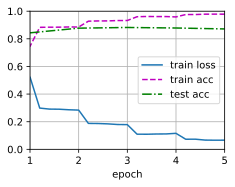

In [23]:
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [24]:
# evaluation
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [25]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 16.4. Natural Language Inference and the Dataset